<a href="https://colab.research.google.com/github/GuidoOliveri11/tesis_MiM_Guido_Luca_Oliveri/blob/main/FINAL_MiM_Tesis_Oliveri_Guido_(RE_y_RI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-optimize
!pip install tpot
!pip install hyperopt
!pip install autogluon.tabular
!pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 14.9

In [2]:
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier                                     # RF clasificacion
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold                                 # Eliminar columnas constantes o casi constantes para el VIF
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB                                              # naive bayes
from sklearn.neighbors import KNeighborsClassifier                                      # K neighbors
from sklearn.model_selection import GridSearchCV                                        # hiperparametros para RL/RF y demas algoritmos
from imblearn.over_sampling import SMOTE, RandomOverSampler                             # para la clase onboarded ajustarla
from collections import Counter                                                         # verificar distribucion onboarded despues del muestreo
from sklearn.model_selection import RandomizedSearchCV                                  # Hiperparametros RandomizedSearchCV    para RF y otros
from skopt import BayesSearchCV                                                         # Hiperparametros Bayesian Optimization para RF y otros
from skopt.space import Integer
from skopt.searchcv import BayesSearchCV
from tpot import TPOTClassifier                                                         # Configurar y ejecutar TPOT para Random Forest
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK                                   # RF hiperparametros Hyperband
from hyperopt.pyll.base import scope                                                    # RF hiperparametros Hyperband
from sklearn.model_selection import cross_val_score                                     # RF hiperparametros Hyperband
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval                       # Import space_eval
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real  # Import necessary classes for defining search spaces
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tpot import TPOTClassifier
from datetime import datetime
from autogluon.tabular import TabularPredictor

# Configuración global de semillas para reproducibilidad
import random
import os
random.seed(11)
np.random.seed(11) # numpy
os.environ['PYTHONHASHSEED'] = '11'


from sklearn.model_selection import StratifiedKFold # folds
from boruta import BorutaPy
import scipy.stats as st
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer



In [3]:
### 1. CARGA DE DATOS ###
url = 'https://drive.google.com/uc?export=download&id=18U5tRawJ_A2Vk9x_Coye_li-Ug352Uds'
output = 'Dataset_2024_09_14.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?export=download&id=18U5tRawJ_A2Vk9x_Coye_li-Ug352Uds
To: /content/Dataset_2024_09_14.csv
100%|██████████| 40.5M/40.5M [00:00<00:00, 78.6MB/s]


In [4]:
#  No tenemos nulos en este dataset. La distribucion es 37% super heavy, 36% stable, 25% heavy y 2% onboarded. La cantidad de observaciones totales es 142.530
print("Cantidad de nulos antes de quitar nulos:", df['dif_dias_4ta_orden_a_max_seg'].isnull().sum())
print("Distribucion de max segmento alcanzado antes de quitar nulos:", df['max_lifecycle'].value_counts())

Cantidad de nulos antes de quitar nulos: 0
Distribucion de max segmento alcanzado antes de quitar nulos: max_lifecycle
4super heavy    52365
2stable         51748
3heavy          36117
1onboarded       2300
Name: count, dtype: int64


In [5]:
#### 2. LIMPIEZA DE VALORES NULOS ###
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:  # chequear si la columna es numerica
        df.dropna(subset=[column], inplace=True)  # elimino filas con valores nulos en columnas numéricas
print(df.dtypes)


user_id                               int64
pais_registro_user                   object
dia_max_segmento_alcanzado           object
dia_semana_max_segmento_alcanzado    object
max_lifecycle                        object
dia_1er_compra                       object
dia_semana_1er_compra                object
vertical_name_1er_compra             object
is_restaurant_or_market_1ra            bool
is_pre_order_1er_compra                bool
is_pickup_1er_compra                   bool
country_1er_compra                   object
dia_2da_compra                       object
dia_semana_2da_compra                object
vertical_name_2da_compra             object
is_restaurant_or_market_2da            bool
is_pre_order_2da_compra                bool
is_pickup_2da_compra                   bool
country_2da_compra                   object
dia_3ra_compra                       object
dia_semana_3ra_compra                object
vertical_name_3ra_compra             object
is_restaurant_or_market_3ra     

In [6]:
print("Cantidad de nulos despues de quitar nulos y antes de quitar outliers:", df['dif_dias_4ta_orden_a_max_seg'].isnull().sum())
print("Distribucion de max segmento alcanzado despues de quitar nulos y antes de quitar outliers:", df['max_lifecycle'].value_counts())

Cantidad de nulos despues de quitar nulos y antes de quitar outliers: 0
Distribucion de max segmento alcanzado despues de quitar nulos y antes de quitar outliers: max_lifecycle
4super heavy    52365
2stable         51748
3heavy          36117
1onboarded       2300
Name: count, dtype: int64


In [7]:
### 2. LIMPIEZA DE OUTLIERS ###
factor=3 # probé con 3.75 y la cantidad post outliers para onboarded en vez de ser 288 (para factor = 3) es 620
def remove_outliers(df, col, factor):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1  # Rango intercuartil
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# limpieza de outliers a columnas numéricas
for col in df.select_dtypes(include=[np.number]).columns:
    df = remove_outliers(df, col, factor)

In [8]:
# Distribucion del máximo segmento alcanzado que obtenemos post sacar outliers es la siguiente: stable 37%, super heavy 37%, heavy 25% y onboarded ~1%. La cantidad de observaciones totales es 126.866
print("Cantidad de nulos post quitar nulos + outliers:", df['dif_dias_4ta_orden_a_max_seg'].isnull().sum())
print("Distribucion de max segmento alcanzado post quitar nulos + outliers:", df['max_lifecycle'].value_counts())

Cantidad de nulos post quitar nulos + outliers: 0
Distribucion de max segmento alcanzado post quitar nulos + outliers: max_lifecycle
2stable         47397
4super heavy    46861
3heavy          32320
1onboarded        288
Name: count, dtype: int64


<ipython-input-9-529a4aa15556>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['max_lifecycle_label'] = df['max_lifecycle'].map(lifecycle_labels)


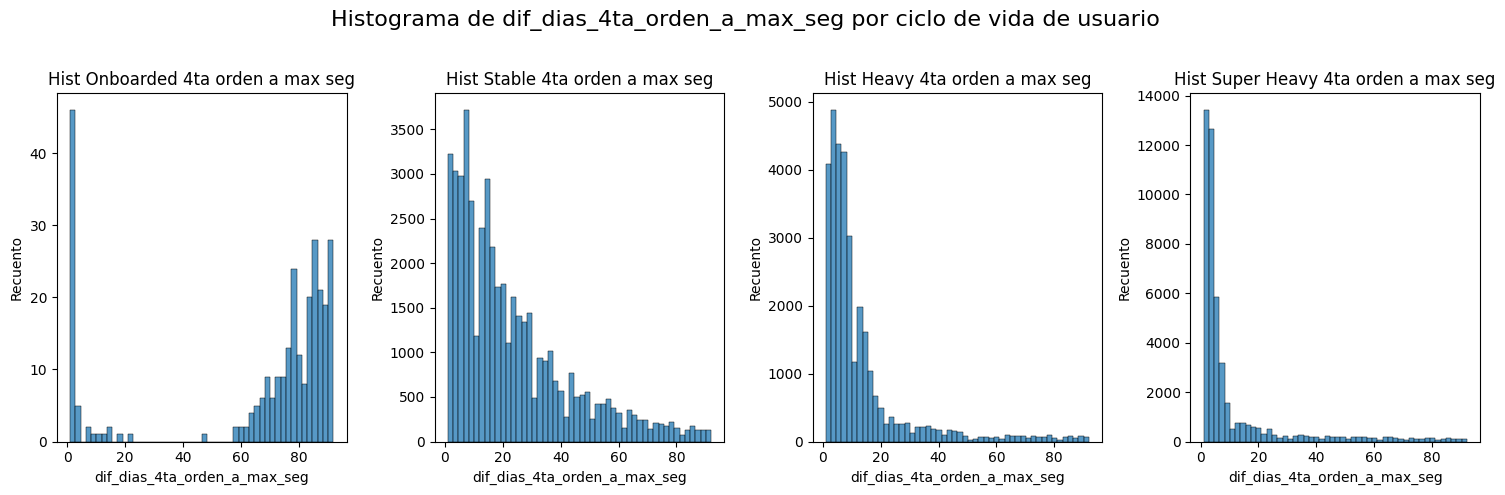

In [9]:
### 3. ANALISIS DESCRIPTIVO (EDA)  ###

######### A)  HISTOGRAMA PARA LA VARIABLE DIA 4TA ORDEN QUE RELACIONA DIA 4TA ORDEN CON DIA MAX SEGMENTO ALCANZADO ########################
lifecycle_labels = {'1onboarded':'Onboarded', '2stable': 'Stable', '3heavy': 'Heavy', '4super heavy': 'Super Heavy'}
df['max_lifecycle_label'] = df['max_lifecycle'].map(lifecycle_labels)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Histograma de dif_dias_4ta_orden_a_max_seg por ciclo de vida de usuario', fontsize=16)

# Histograma para la clase 'Onboarded'
sns.histplot(df[df['max_lifecycle_label'] == 'Onboarded']['dif_dias_4ta_orden_a_max_seg'], bins=50, ax=axes[0])
axes[0].set_title('Hist Onboarded 4ta orden a max seg')
axes[0].set_xlabel('dif_dias_4ta_orden_a_max_seg')
axes[0].set_ylabel('Recuento')

# Histograma para la clase 'Stable'
sns.histplot(df[df['max_lifecycle_label'] == 'Stable']['dif_dias_4ta_orden_a_max_seg'], bins=50, ax=axes[1])
axes[1].set_title('Hist Stable 4ta orden a max seg')
axes[1].set_xlabel('dif_dias_4ta_orden_a_max_seg')
axes[1].set_ylabel('Recuento')

# Histograma para la clase 'Heavy'
sns.histplot(df[df['max_lifecycle_label'] == 'Heavy']['dif_dias_4ta_orden_a_max_seg'], bins=50, ax=axes[2])
axes[2].set_title('Hist Heavy 4ta orden a max seg')
axes[2].set_xlabel('dif_dias_4ta_orden_a_max_seg')
axes[2].set_ylabel('Recuento')

# Histograma para la clase 'Super Heavy'
sns.histplot(df[df['max_lifecycle_label'] == 'Super Heavy']['dif_dias_4ta_orden_a_max_seg'], bins=50, ax=axes[3])
axes[3].set_title('Hist Super Heavy 4ta orden a max seg')
axes[3].set_xlabel('dif_dias_4ta_orden_a_max_seg')
axes[3].set_ylabel('Recuento')

# Ajustar el espaciado entre los subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

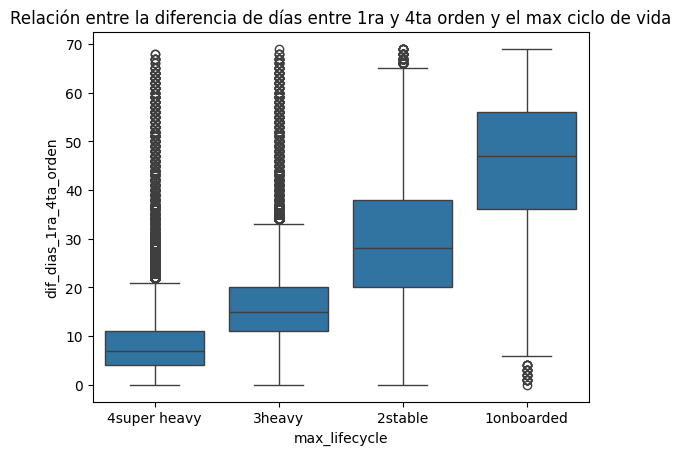

In [10]:
############ B) BOXPLOT Relación entre el Tiempo Transcurrido entre Órdenes (Frecuencia de Compra) y max_lifecycle ########################
sns.boxplot(x='max_lifecycle', y='dif_dias_1ra_4ta_orden', data=df)
plt.title('Relación entre la diferencia de días entre 1ra y 4ta orden y el max ciclo de vida')
plt.show()

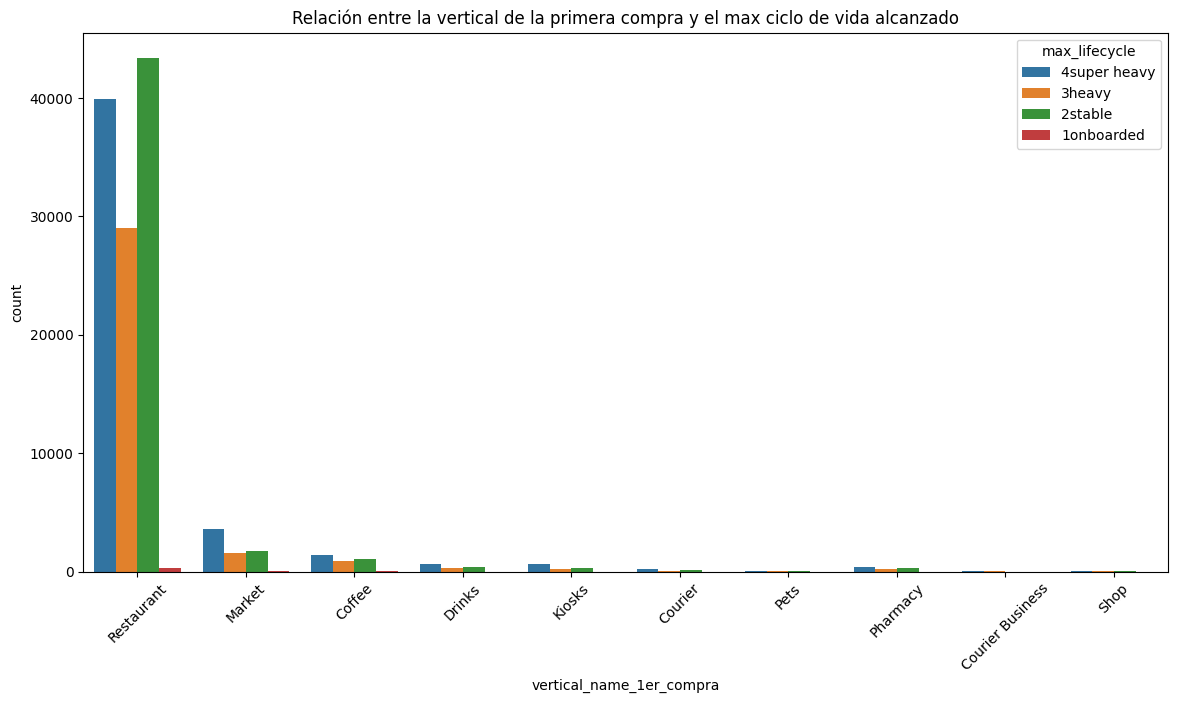

In [11]:
############ C.1) GRAFICO DE BARRAS Relación entre la Vertical de la Primera Compra y `max_lifecycle`: ########################
plt.figure(figsize=(14, 7))
sns.countplot(x='vertical_name_1er_compra', hue='max_lifecycle', data=df)
plt.title('Relación entre la vertical de la primera compra y el max ciclo de vida alcanzado')
plt.xticks(rotation=45)
plt.show()

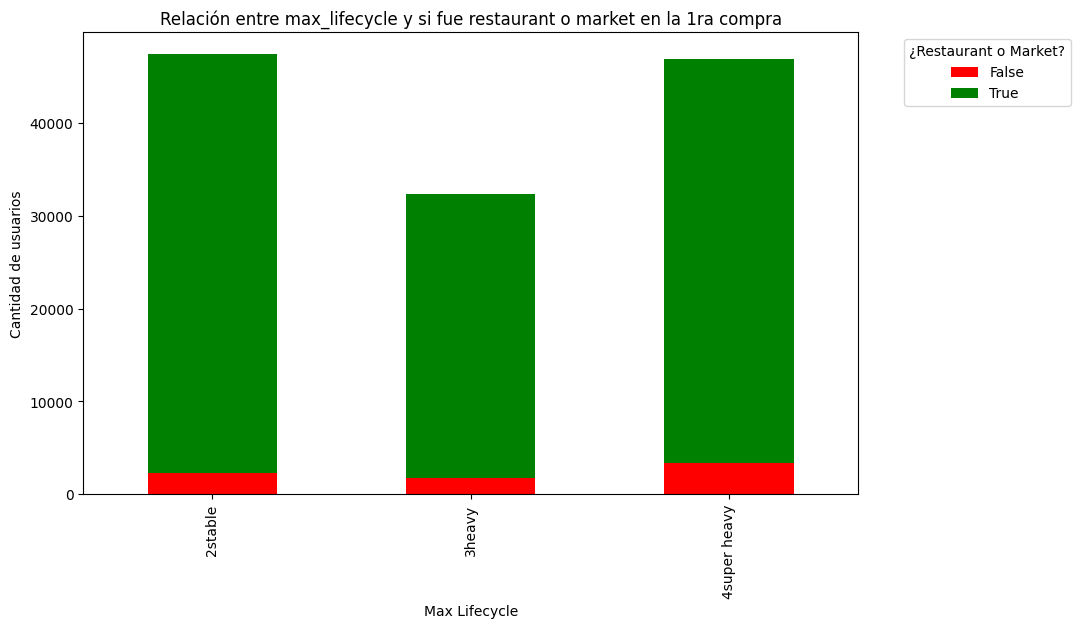

In [12]:
############ C.2) GRAFICO DE BARRAS APILADAS Relación entre is_restaurant_or_market_1ra y `max_lifecycle`: ########################
df_filtered = df[df['max_lifecycle'] != '1onboarded'] # Filtrar el dataframe para excluir '1onboarded'

crosstab = pd.crosstab(df_filtered['max_lifecycle'], df_filtered['is_restaurant_or_market_1ra'])

crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green'])

plt.title('Relación entre max_lifecycle y si fue restaurant o market en la 1ra compra')
plt.xlabel('Max Lifecycle')
plt.ylabel('Cantidad de usuarios')
plt.legend(title='¿Restaurant o Market?', labels=['False', 'True'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<ipython-input-13-83fef4668dda>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(crosstab_percentage, annot=crosstab_percentage.applymap(lambda v: f'{v:.0f}%'), cmap="YlGnBu", fmt="")


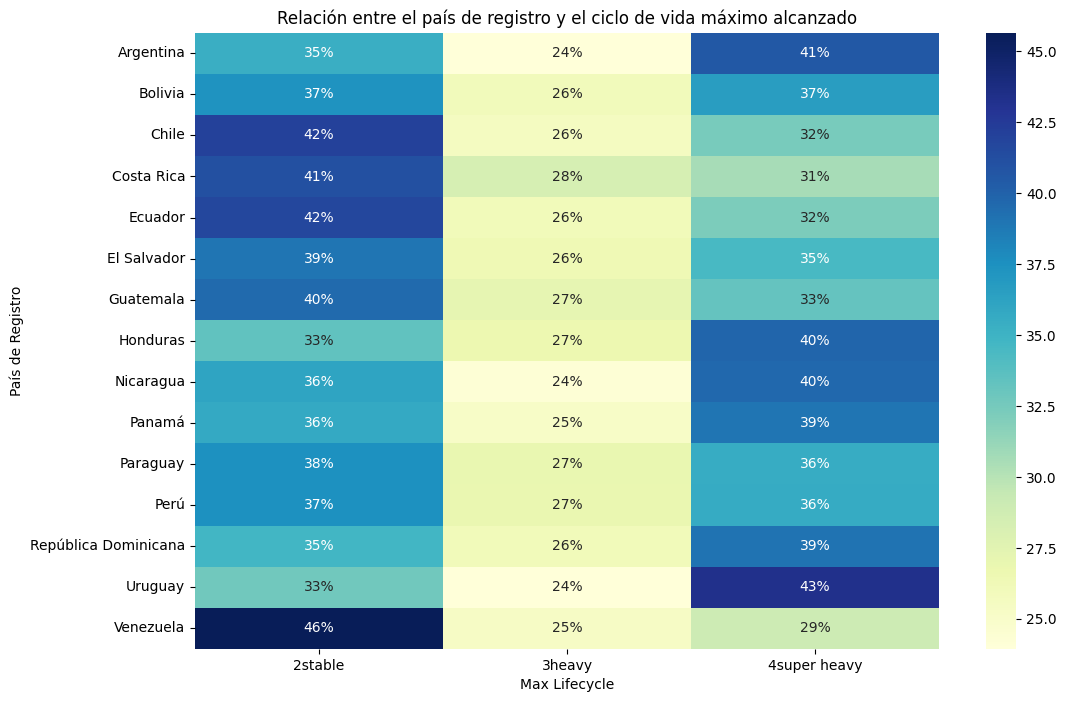

In [13]:
############ D) HEATMAP Relación entre el País de Registro y max_lifecycle ########################

# Excluir '1onboarded' de la columna 'max_lifecycle'
df_filtered = df[df['max_lifecycle'] != '1onboarded']

# Crear la tabla de contingencia con los datos filtrados
crosstab_percentage = pd.crosstab(df_filtered['pais_registro_user'], df_filtered['max_lifecycle'], normalize='index') * 100

plt.figure(figsize=(12, 8))
sns.heatmap(crosstab_percentage, annot=crosstab_percentage.applymap(lambda v: f'{v:.0f}%'), cmap="YlGnBu", fmt="")

plt.title('Relación entre el país de registro y el ciclo de vida máximo alcanzado')
plt.xlabel('Max Lifecycle')
plt.ylabel('País de Registro')

plt.show()


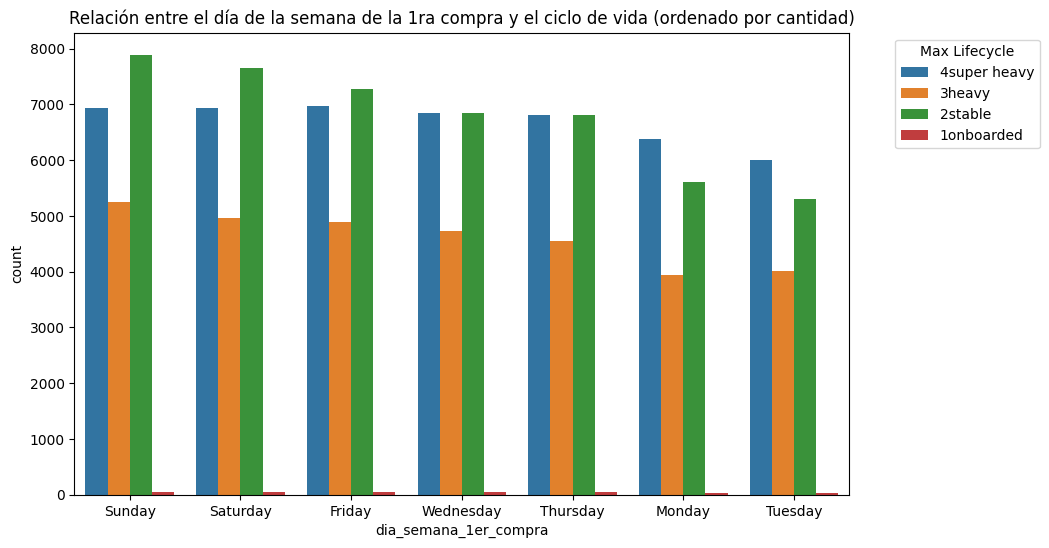

In [14]:
############ E) GRAFICO DE BARRAS Relación entre el Día de la Semana de la Primera Compra y max_lifecycle ########################
df_day_order = df.groupby('dia_semana_1er_compra').size().reset_index(name='count')

df_day_order = df_day_order.sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 6))
sns.countplot(x='dia_semana_1er_compra', hue='max_lifecycle', data=df, order=df_day_order['dia_semana_1er_compra'])

plt.legend(title='Max Lifecycle', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Relación entre el día de la semana de la 1ra compra y el ciclo de vida (ordenado por cantidad)')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

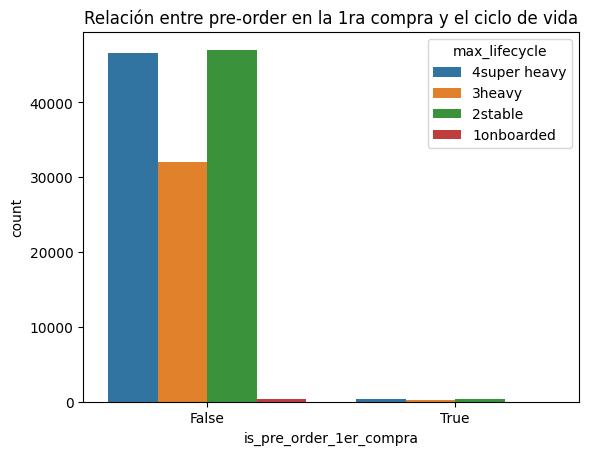

In [15]:
############ F) GRAFICO DE BARRAS Relación entre el Uso de Pre-Orders en la Primera Compra y `max_lifecycle` ########################
sns.countplot(x='is_pre_order_1er_compra', hue='max_lifecycle', data=df)
plt.title('Relación entre pre-order en la 1ra compra y el ciclo de vida')
plt.show

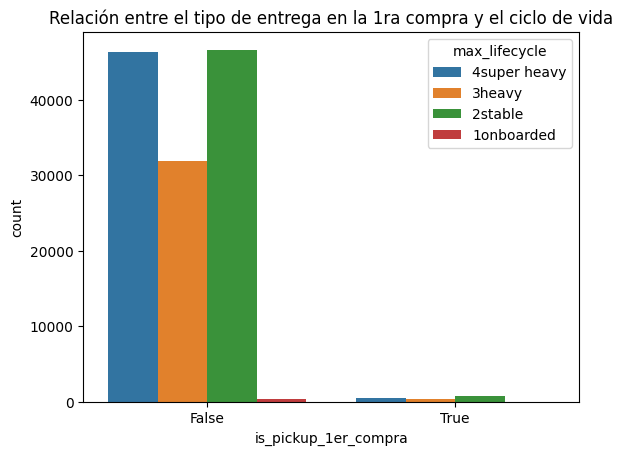

In [16]:
############ G) GRAFICO DE BARRAS  Relación entre el Tipo de Entrega de la Primera Compra (Pickup vs. Delivery) y `max_lifecycle` ########################
sns.countplot(x='is_pickup_1er_compra', hue='max_lifecycle', data=df)
plt.title('Relación entre el tipo de entrega en la 1ra compra y el ciclo de vida')
plt.show()

In [17]:
# H) Cuadro de resultados con el promedio de ordenes (variable para el feature engineering luego)

# Convertir las columnas de fecha a tipo datetime para calcular diferencias de días
df['dia_1er_compra'] = pd.to_datetime(df['dia_1er_compra'])
df['dia_2da_compra'] = pd.to_datetime(df['dia_2da_compra'])
df['dia_3ra_compra'] = pd.to_datetime(df['dia_3ra_compra'])
df['dia_4ta_compra'] = pd.to_datetime(df['dia_4ta_compra'])

# calculo diferencias entre cada par de órdenes
df['dif_1er_2da'] = df['dia_2da_compra'] - df['dia_1er_compra']
df['dif_2da_3ra'] = df['dia_3ra_compra'] - df['dia_2da_compra']
df['dif_3ra_4ta'] = df['dia_4ta_compra'] - df['dia_3ra_compra']

df['avg_days_between_orders'] = (df['dif_1er_2da'] + df['dif_2da_3ra'] + df['dif_3ra_4ta']) / 3

df['avg_days_between_orders'] = df['avg_days_between_orders'].dt.total_seconds() / (24 * 3600)

avg_days_per_segment = df.groupby('max_lifecycle')['avg_days_between_orders'].mean()

avg_days_per_segment

,avg_days_between_orders
max_lifecycle,
1onboarded,14.280093
2stable,9.726347
3heavy,5.506291
4super heavy,2.947519


In [18]:
## Preprocesamiento de datos
# Convertir fechas a tipo datetime
df['dia_max_segmento_alcanzado'] = pd.to_datetime(df['dia_max_segmento_alcanzado'])

# Crear nuevas características a partir de las fechas
df['year_1er_compra'] = df['dia_1er_compra'].dt.year
df['month_1er_compra'] = df['dia_1er_compra'].dt.month
df['day_1er_compra'] = df['dia_1er_compra'].dt.day

df['year_2da_compra'] = df['dia_2da_compra'].dt.year
df['month_2da_compra'] = df['dia_2da_compra'].dt.month
df['day_2da_compra'] = df['dia_2da_compra'].dt.day

df['year_3ra_compra'] = df['dia_3ra_compra'].dt.year
df['month_3ra_compra'] = df['dia_3ra_compra'].dt.month
df['day_3ra_compra'] = df['dia_3ra_compra'].dt.day

df['year_4ta_compra'] = df['dia_4ta_compra'].dt.year
df['month_4ta_compra'] = df['dia_4ta_compra'].dt.month
df['day_4ta_compra'] = df['dia_4ta_compra'].dt.day

df['year_max_segmento'] = df['dia_max_segmento_alcanzado'].dt.year
df['month_max_segmento'] = df['dia_max_segmento_alcanzado'].dt.month
df['day_max_segmento'] = df['dia_max_segmento_alcanzado'].dt.day



max_lifecycle  1onboarded  2stable  3heavy  4super heavy
year_month                                              
2024-01                 9       64    2240          9285
2024-02                35    11643   15486         20778
2024-03                17    25427   11903         13025
2024-04                 1     7923    1781          2395
2024-05               187     2224     832          1272


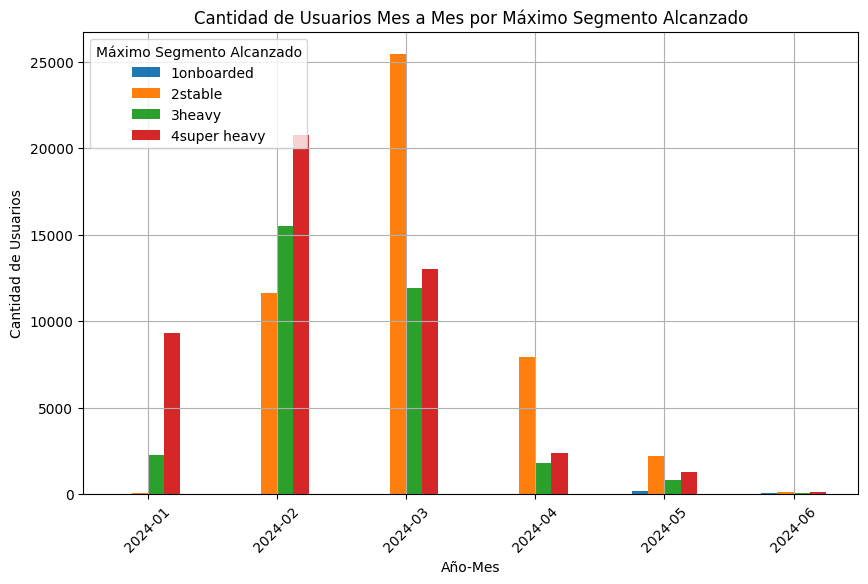

In [19]:
# I) gráfico de barras para ver la cantidad de usuarios por segmento máximo alcanzado mes a mes
usuarios_por_mes = df.groupby(['year_max_segmento', 'month_max_segmento', 'max_lifecycle'])['user_id'].nunique().reset_index()
usuarios_por_mes['year_month'] = usuarios_por_mes['year_max_segmento'].astype(str) + '-' + usuarios_por_mes['month_max_segmento'].astype(str).str.zfill(2)

usuarios_por_mes.rename(columns={'user_id': 'cantidad_usuarios'}, inplace=True)

usuarios_por_mes_pivot = usuarios_por_mes.pivot(index='year_month', columns='max_lifecycle', values='cantidad_usuarios')

usuarios_por_mes_pivot = usuarios_por_mes_pivot.fillna(0)  # Relleno valores NaN con 0 (en caso de que no haya usuarios en algún mes para ciertos segmentos)

print(usuarios_por_mes_pivot.head())

# Cambiar de gráfico de líneas a gráfico de barras
usuarios_por_mes_pivot.plot(kind='bar', figsize=(10, 6))

plt.title('Cantidad de Usuarios Mes a Mes por Máximo Segmento Alcanzado')
plt.xlabel('Año-Mes')
plt.ylabel('Cantidad de Usuarios')
plt.xticks(rotation=45)
plt.legend(title='Máximo Segmento Alcanzado', loc='upper left')

plt.grid(True)
plt.show()

In [20]:
df = df.drop(columns=['dia_1er_compra', 'dia_2da_compra', 'dia_3ra_compra', 'dia_4ta_compra', 'dia_max_segmento_alcanzado']) # estas ya las dropeo de mi dataset y uso lo de arriba

In [21]:
###################### 4. FEATURE ENGINEERING  #############################################
# hecho en la query tengo
# A) dif_dias_1ra_4ta_orden
# B) dif_dias_4ta_orden_a_hoy
# C) dif_dias_4ta_orden_a_max_seg
# D) dif_dias_1er_orden_a_max_seg
# E) avg_days_per_segment
# F) log_avg_days_between_orders
df['log_avg_days_between_orders'] = np.log1p(df['avg_days_between_orders'])

# Definir columnas categóricas -> No uso dia_semana_max_segmento_alcanzado en el one hot encoding
categorical_columns = ['pais_registro_user'                            , 'dia_semana_1er_compra',
                       'vertical_name_1er_compra', 'country_1er_compra', 'dia_semana_2da_compra',
                       'vertical_name_2da_compra', 'country_2da_compra', 'dia_semana_3ra_compra',
                       'vertical_name_3ra_compra', 'country_3ra_compra', 'dia_semana_4ta_compra',
                       'vertical_name_4ta_compra', 'country_4ta_compra']

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True) # Aplicar One-Hot Encoding a columnas categóricas

print(df.head())

    user_id dia_semana_max_segmento_alcanzado max_lifecycle  \
1  70591858                         Wednesday  4super heavy   
2  70592125                         Wednesday  4super heavy   
3  70604050                            Monday        3heavy   
4  70602102                          Thursday  4super heavy   
5  70613721                            Friday  4super heavy   

   is_restaurant_or_market_1ra  is_pre_order_1er_compra  is_pickup_1er_compra  \
1                         True                    False                 False   
2                         True                    False                 False   
3                         True                    False                 False   
4                         True                    False                 False   
5                        False                    False                 False   

   is_restaurant_or_market_2da  is_pre_order_2da_compra  is_pickup_2da_compra  \
1                         True                    Fal

In [22]:
### 5. DROPEO DE COLUMNAS + PREDICCION  ###
X = df.drop(columns= ['user_id', 'max_lifecycle', 'year_max_segmento', 'month_max_segmento',
                     'day_max_segmento', 'dia_semana_max_segmento_alcanzado',
                     'dif_dias_4ta_orden_a_hoy', 'dif_dias_4ta_orden_a_max_seg',
                     'dif_dias_1er_orden_a_max_seg', 'max_lifecycle_label'])

##########################################################################################################
############ MULTICOLINEALIDAD

############ VIF ###########
# # Eliminar variables con baja varianza
# selector = VarianceThreshold(threshold=0.01)
# selector.fit(X)
# X_filtered = X[X.columns[selector.get_support(indices=True)]]

# # Agregar una constante (columna de 1s) al conjunto de datos
# X_with_const = sm.add_constant(X_filtered)  # Añade la constante

# # Crear un DataFrame para guardar los resultados de VIF
# vif_data = pd.DataFrame()
# vif_data["Variable"] = X_filtered.columns  # No incluir la constante aquí

# # Escalar solo las variables explicativas (sin la constante)
# scalerVIF = StandardScaler()
# X_scaled = scalerVIF.fit_transform(X_filtered)  # Solo escalar X_filtered

# # Calcular el VIF con las variables escaladas (ignorar la constante)
# vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# # Imprimir el resultado
# print("El dataframe de VIF es:", vif_data)


############ MATRIZ DE CORRELACION ###########
######################### POR AHORA LA COMENTO
# n_variables_per_heatmap = 20 # num_columnas / 20 => 155 / 20

# # Dividir las columnas de la matriz de correlación en grupos
# columns = X.columns
# column_groups = [columns[i:i + n_variables_per_heatmap] for i in range(0, len(columns), n_variables_per_heatmap)]

# # Crear un heatmap para cada grupo de columnas
# for i, group in enumerate(column_groups):
#     plt.figure(figsize=(20, 16))
#     corr_matrix_group = X[group].corr()  # Sub-matriz de correlación para este grupo
#     sns.heatmap(corr_matrix_group, annot=True, cmap='Reds', vmin=-1, vmax=1, center=0, fmt=".2f",
#                 linewidths=.5, cbar_kws={"shrink": .8})
#     plt.title(f'Matriz de correlación entre las variables - Grupo {i+1}', fontsize=16)
#     plt.xticks(rotation=45, ha='right', fontsize=10)
#     plt.yticks(fontsize=10)
#     plt.tight_layout()  # Ajustar el layout para que todo encaje bien
#     plt.show()

In [23]:
y = df['max_lifecycle']

# # (4super heavy > 3 heavy > 2stable > 1onboarded), voy a usar label encoder para codificar la variable objetivo
# Eliminar la clase 'Onboarded' de y
y_filtered = y[y != '1onboarded']
X_filtered = X.loc[y != '1onboarded']

# Ahora aplicamos el LabelEncoder solo a las clases restantes
le = LabelEncoder()
y_filtered = le.fit_transform(y_filtered)

# Clases después del LabelEncoder (serían 0, 1, 2): ['2stable' '3heavy' '4super heavy']
print("Clases después del LabelEncoder (serían 0, 1, 2):", le.classes_)

# Convertir columnas de tiempo a segundos
for column in X_filtered.select_dtypes(include=['timedelta64[ns]']).columns:
    X_filtered[column] = X_filtered[column].dt.total_seconds() / (24 * 3600)

# Dividir en entrenamiento y test (manteniendo test aparte) => con stratify=y_filtered al final
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=11, stratify=y_filtered)

# Aplicar escalado solo a los datos de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Clases después del LabelEncoder (serían 0, 1, 2): ['2stable' '3heavy' '4super heavy']


<ipython-input-23-604924bea8f4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_filtered[column] = X_filtered[column].dt.total_seconds() / (24 * 3600)


In [24]:
#############################################################
#############################################################
################# C V   P A R A   B O R U T A ###############
#############################################################
#############################################################
# Aplicar validación cruzada en Boruta
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
selected_features = np.zeros(X_train_scaled.shape[1])  # Para contar qué variables son seleccionadas en cada fold

for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=3, random_state=11)
    boruta = BorutaPy(rf, n_estimators=100, verbose=2, random_state=11, max_iter=20, perc=90)  # Optimizado porque sino no terminaba

    # Usar solo una muestra para Boruta
    sample_size = min(5000, X_train_fold.shape[0])  # Acelera Boruta con solo 5000 filas
    idx_sample = np.random.choice(X_train_fold.shape[0], sample_size, replace=False)
    boruta.fit(X_train_fold[idx_sample], y_train_fold[idx_sample])

    selected_features += boruta.support_

# Seleccionar solo las variables que fueron elegidas en la mayoría de los folds
threshold = cv.get_n_splits() // 2  # Al menos en la mitad de los folds
final_selected_features = selected_features >= threshold

X_train_selected = X_train_scaled[:, final_selected_features]
X_test_selected = X_test_scaled[:, final_selected_features]

# print("Datos de X entrenamiento escalados en formato cantidad filas-columnas", X_train_scaled.shape)              # Datos de X entrenamiento escalados en formato cantidad filas-columnas (101262, 160)
# print("Datos de X testeo escalados en formato cantidad filas-columnas",        X_test_scaled.shape)               # Datos de X testeo escalados en formato cantidad filas-columnas (25316, 160)
selected_feature_names = X_train.columns[final_selected_features]
print("Variables seleccionadas por Boruta:")
print(selected_feature_names)
print(f"Número de variables seleccionadas por Boruta con CV: {X_train_selected.shape[1]}")                        # Número de variables seleccionadas por Boruta con CV: 20
print("Datos de X entrenamiento escalados en formato cantidad filas-columnas con Boruta", X_train_selected.shape) # Datos de X entrenamiento escalados en formato cantidad filas-columnas con Boruta (101262, 20)
print("Datos de X testeo escalados en formato cantidad filas-columnas con Boruta",        X_test_selected.shape)  # Datos de X testeo escalados en formato cantidad filas-columnas con Boruta (25316, 20)


Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	160
Rejected: 	0
Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	160
Rejected: 	0
Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	160
Rejected: 	0
Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	160
Rejected: 	0
Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	160
Rejected: 	0
Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	160
Rejected: 	0
Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	160
Rejected: 	0
Iteration: 	8 / 20
Confirmed: 	17
Tentative: 	48
Rejected: 	95
Iteration: 	9 / 20
Confirmed: 	17
Tentative: 	48
Rejected: 	95
Iteration: 	10 / 20
Confirmed: 	17
Tentative: 	48
Rejected: 	95
Iteration: 	11 / 20
Confirmed: 	17
Tentative: 	48
Rejected: 	95
Iteration: 	12 / 20
Confirmed: 	18
Tentative: 	28
Rejected: 	114
Iteration: 	13 / 20
Confirmed: 	18
Tentative: 	28
Rejected: 	114
Iteration: 	14 / 20
Confirmed: 	18
Tentative: 	28
Rejected: 	114
Iteration: 	15 / 20
Confirmed: 	18
Tentative: 	28
Rejected: 	114
Iteration: 	16 / 20
Confirmed: 	18
Tentative: 	16
Re

In [25]:
# # Definir validación cruzada y métricas
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)
# scoring = ['accuracy']  # Solo accuracy para modelos que no son los dos mejores

def confidence_interval(scores):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    n_folds = len(scores)
    ci_lower, ci_upper = st.t.interval(0.95, df=n_folds-1, loc=mean_score, scale=std_score/np.sqrt(n_folds))
    return mean_score, (ci_lower, ci_upper)

# # Modelos que usan solo accuracy en 10-fold CV
# models = {
#     'KNN': KNeighborsClassifier(n_neighbors=7),
#     'Logistic Regression': LogisticRegression(max_iter=1000),
#     'SVM': SVC()
# }

In [27]:
#####################################################################
# K  N E I G H B O R S
# Usar validación cruzada en el conjunto de entrenamiento
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11) # QUEDA K=10
knn = KNeighborsClassifier(n_neighbors=7)
cross_val_scores = cross_val_score(knn, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores:", cross_val_scores)
print("Mean CV Accuracy:", mean_cv_accuracy)

####################################################################
# Entrenar el modelo final con todo el conjunto de entrenamiento
knn.fit(X_train_selected, y_train)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred = knn.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy en Test KNN:", test_accuracy)
print("\nConfusion Matrix KNN:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report KNN:\n", classification_report(y_test, y_pred))

#######################################
# K-fold=10 y KNN = 7 + BORUTA
# Cross-validation scores: [0.65063691 0.66001777 0.65929291 0.65494766 0.65326881 0.65475015
#  0.65277503 0.66215682 0.6539601  0.65435513]
# Mean CV Accuracy: 0.6556161302124679
# (ESTE VA) Accuracy en Test KNN: 0.6539737715278875

# Antes
# Accuracy KNN: 0.5766313793648286


Cross-validation scores: [0.65063691 0.66001777 0.65929291 0.65494766 0.65326881 0.65475015
 0.65277503 0.66215682 0.6539601  0.65435513]
Mean CV Accuracy: 0.6556161302124679
Accuracy en Test KNN: 0.6539737715278875

Confusion Matrix KNN:
 [[7037 1551  892]
 [2076 2708 1680]
 [1023 1538 6811]]

Classification Report KNN:
               precision    recall  f1-score   support

           0       0.69      0.74      0.72      9480
           1       0.47      0.42      0.44      6464
           2       0.73      0.73      0.73      9372

    accuracy                           0.65     25316
   macro avg       0.63      0.63      0.63     25316
weighted avg       0.65      0.65      0.65     25316



In [28]:
####################################################################
# Entrenamiento de R E G R E S I O N  L O G I S T I C A
# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)
model_RL = LogisticRegression(max_iter=1000, random_state=11)
cross_val_scores = cross_val_score(model_RL, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores RL:", cross_val_scores)
print("Mean CV Accuracy RL:", mean_cv_accuracy)

# Entrenar el modelo final con todo el conjunto de entrenamiento
model_RL.fit(X_train_selected, y_train)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred = model_RL.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy en Test RL:", test_accuracy)
print("\nConfusion Matrix RL:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RL:\n", classification_report(y_test, y_pred))

# Cross-validation scores RL: [0.68756789 0.69181396 0.695635   0.68980841 0.68882086 0.69316611
#  0.69405491 0.69365989 0.69425242 0.69701758]
# Mean CV Accuracy RL: 0.6925797019370876
# (ESTE VA) Accuracy en Test RL: 0.6893664085953547

#Antes
#Accuracy RL: 0.6894454100173804

Cross-validation scores RL: [0.68756789 0.69181396 0.695635   0.68980841 0.68882086 0.69316611
 0.69405491 0.69365989 0.69425242 0.69701758]
Mean CV Accuracy RL: 0.6925797019370876
Accuracy en Test RL: 0.6893664085953547

Confusion Matrix RL:
 [[7227 1433  820]
 [1818 3098 1548]
 [ 860 1385 7127]]

Classification Report RL:
               precision    recall  f1-score   support

           0       0.73      0.76      0.75      9480
           1       0.52      0.48      0.50      6464
           2       0.75      0.76      0.76      9372

    accuracy                           0.69     25316
   macro avg       0.67      0.67      0.67     25316
weighted avg       0.68      0.69      0.69     25316



In [34]:
# R E G R E S I O N  L O G I S T I C A    C O N   H I P E R P A R A M E T R O S
start_time = datetime.now()
print("Hora de inicio:", start_time)

# ######################################################################################################################################
# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

# ######## Caso 1 |  Penalty Ridge Regularization con valores de hiperparámetros
# # =====> Hipótesis Caso 1: entender la performance de los hiperparametros si es mejor o peor que el RL sin hiperparametros. Y ver con iteraciones de mejorarla
# param_grid = {
#     'C': [0.001, 0.01],
#     'solver': ['liblinear'],
#     'penalty': ['l2'],
#     'max_iter': [5,10]
# }

# ###### Resultado
# Cross-validation scores RL: [0.68391429 0.68934531 0.69128975 0.68664823 0.69010468 0.69227731
#  0.68941339 0.69237606 0.69119099 0.69365989]
# Mean CV Accuracy RL: 0.6900219903258638
# Hora de finalización: 2025-03-08 20:41:33.666913
# Tiempo de ejecución: 0:01:49.825143
# Mejores hiperparámetros encontrados RL: {'C': 0.01, 'max_iter': 5, 'penalty': 'l2', 'solver': 'liblinear'}
# (ESTE VA) Accuracy en Test RL: 0.687154368778638

# Antes -> Accuracy RL con mejores hiperparámetros RL:  0.6868383630905356

# #######################################################################################################################################
# ######## Caso 2 |  Penalty Ridge Regularization con mas valores de los mismos hiperparámetros
# # =====> Hipótesis Caso 2: entender si a mayor C y a mayor max iter, performa mejor, pruebo la siguiente casuistica:
# param_grid = {
#     'C': [0.001, 0.01, 0.1],
#     'solver': ['liblinear'],
#     'penalty': ['l2'],
#     'max_iter': [5,10,15]
# }

# ###### Resultado
# Cross-validation scores RL: [0.68569172 0.69250518 0.69494371 0.68862335 0.69000593 0.69504246
#  0.69326486 0.69464744 0.69346237 0.69721509]
# Mean CV Accuracy RL: 0.6925402113677721
# Hora de finalización: 2025-03-08 20:34:56.876191
# Tiempo de ejecución: 0:03:56.705133
# Mejores hiperparámetros encontrados RL: {'C': 0.1, 'max_iter': 5, 'penalty': 'l2', 'solver': 'liblinear'}
# (ESTE VA) Accuracy en Test RL: 0.6894059093063675

# Antes -> Accuracy RL con mejores hiperparámetros RL: 0.6887738979301627

# #######################################################################################################################################
# ######## Caso 3 |  Penalty Lasso Regularization con mismos valores de hiperparámetros C y max_iter
# # =====> Hipótesis Caso 3: entender si con Lasso puedo mejorar el accuracy obtenido en caso 2 de hiperparametros de RL
# # ya que dió mejor con estos parametros de C y de max_iter, los mantengo y vario la penalty, y por ende tambien vario el solver

# param_grid = {
#     'C': [0.001, 0.01, 0.1],
#     'solver': ['liblinear','saga'],     # Uso los dos solver para Lasso
#     'penalty': ['l1'],                  # Ahora Lasso
#     'max_iter': [5,10,15]
# }

# ###### Resultado
#  (Antes) Debido a que no converge y que me pide incrementar el nro de iteraciones en el output que obtuve como resultado, voy a cambiar ciertos valores

# Cross-validation scores RL: [0.68746914 0.69240644 0.69603002 0.69030219 0.68842583 0.69365989
#  0.69444993 0.69316611 0.69425242 0.6965238 ]
# Mean CV Accuracy RL: 0.6926685771718335
# Hora de finalización: 2025-03-08 20:46:51.998283
# Tiempo de ejecución: 0:03:06.175139
# Mejores hiperparámetros encontrados RL: {'C': 0.1, 'max_iter': 15, 'penalty': 'l1', 'solver': 'saga'}
# (ESTE VA) Accuracy en Test RL: 0.6895639121504187



# #######################################################################################################################################
# ######## Caso 4 |  Penalty Lasso Regularization c otros valores


# param_grid = {
#     'C': [0.01, 0.1, 1],       # Ajuste en los valores de C -> uso C mas grandes ya que valores pequeños de C pueden hacer que el modelo tenga dificultades para ajustar los datos
#     'solver': ['saga'],        # Usar solo saga para Lasso (es gralmente mas adecuado y puede converger mas rapido que liblinear)
#     'penalty': ['l1'],
#     'max_iter': [50, 100, 150] # incremento iteraciones x10 veces en cada valor
# }

# ###### Resultado
# (Antes) Como no termina tampoco, por ende dejo 1 valor de C (el mayor que es 1), y dejo 1 iteracion y subo mucho la cantidad de max_iter

# Cross-validation scores RL: [0.68756789 0.69290017 0.6965238  0.69000593 0.68891961 0.69365989
#  0.69336362 0.69415366 0.69306735 0.69761011]
# Mean CV Accuracy RL: 0.6927772025670976
# Hora de finalización: 2025-03-08 20:57:23.960607
# Tiempo de ejecución: 0:07:54.238812
# Mejores hiperparámetros encontrados RL: {'C': 1, 'max_iter': 150, 'penalty': 'l1', 'solver': 'saga'}
# (ESTE VA) Accuracy en Test RL: 0.6895244114394059

# #######################################################################################################################################
# ######## Caso 5 |  Penalty Lasso Regularization c otros valores
param_grid = {
    'C': [1],
    'solver': ['saga'],
    'penalty': ['l1'],
    'max_iter': [1000]
}

# ###### Resultado
# (Antes) corrí asi mas de 20 minutos y no convergió con estos parametros, por ende no voy a utilizar Lasso, sino que me quedo con Ridge directo y sus variantes

# Cross-validation scores RL: [0.68756789 0.69280142 0.6965238  0.69000593 0.68891961 0.69356113
#  0.69326486 0.69415366 0.69306735 0.69770887]
# Mean CV Accuracy RL: 0.6927574524065795
# Hora de finalización: 2025-03-08 21:03:57.648307
# Tiempo de ejecución: 0:04:58.841547
# Mejores hiperparámetros encontrados RL: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
# (ESTE VA) Accuracy en Test RL: 0.6895244114394059


# ######################################################################################################################
# ######################################################################################################################
# ######################################################################################################################
# Configurar la búsqueda en cuadrícula con validación cruzada de 10 folds
grid_search = GridSearchCV(LogisticRegression(random_state=11), param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)
best_model_RL = grid_search.best_estimator_

# Evaluar con validación cruzada en el conjunto de entrenamiento
cross_val_scores = cross_val_score(best_model_RL, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores RL:", cross_val_scores)
print("Mean CV Accuracy RL:", mean_cv_accuracy)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred = best_model_RL.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

end_time = datetime.now()
print("Hora de finalización:", end_time)

execution_time = end_time - start_time
print("Tiempo de ejecución:", execution_time)

print("Mejores hiperparámetros encontrados RL:", grid_search.best_params_)
print("Accuracy en Test RL:", test_accuracy)
print("\nConfusion Matrix RL:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RL:\n", classification_report(y_test, y_pred))

Hora de inicio: 2025-03-08 20:58:58.806760
Cross-validation scores RL: [0.68756789 0.69280142 0.6965238  0.69000593 0.68891961 0.69356113
 0.69326486 0.69415366 0.69306735 0.69770887]
Mean CV Accuracy RL: 0.6927574524065795
Hora de finalización: 2025-03-08 21:03:57.648307
Tiempo de ejecución: 0:04:58.841547
Mejores hiperparámetros encontrados RL: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Accuracy en Test RL: 0.6895244114394059

Confusion Matrix RL:
 [[7225 1433  822]
 [1809 3106 1549]
 [ 855 1392 7125]]

Classification Report RL:
               precision    recall  f1-score   support

           0       0.73      0.76      0.75      9480
           1       0.52      0.48      0.50      6464
           2       0.75      0.76      0.76      9372

    accuracy                           0.69     25316
   macro avg       0.67      0.67      0.67     25316
weighted avg       0.69      0.69      0.69     25316



In [35]:
######################################################################
# Entrenamiento del R A N D O M    F O R E S T

# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

# Entrenamiento del R A N D O M    F O R E S T
model_RF = RandomForestClassifier(random_state=11)
cross_val_scores = cross_val_score(model_RF, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores RF:", cross_val_scores)
print("Mean CV Accuracy RF:", mean_cv_accuracy)

# Entrenar el modelo final con todo el conjunto de entrenamiento
model_RF.fit(X_train_selected, y_train)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred = model_RF.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy en Test RF:", test_accuracy)
print("\nConfusion Matrix RF:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF:\n", classification_report(y_test, y_pred))

# Antes Accuracy RF: 0.6689050402907253

# Cross-validation scores RF: [0.64757579 0.65192061 0.65257752 0.64833103 0.6512937  0.65060241
#  0.65079992 0.65702153 0.65336757 0.6504049 ]
# Mean CV Accuracy RF: 0.6513894973691904
# (ESTE VA) Accuracy en Test RF: 0.648404171275083

Cross-validation scores RF: [0.64757579 0.65192061 0.65257752 0.64833103 0.6512937  0.65060241
 0.65079992 0.65702153 0.65336757 0.6504049 ]
Mean CV Accuracy RF: 0.6513894973691904
Accuracy en Test RF: 0.648404171275083

Confusion Matrix RF:
 [[6893 1664  923]
 [1976 2792 1696]
 [1106 1536 6730]]

Classification Report RF:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71      9480
           1       0.47      0.43      0.45      6464
           2       0.72      0.72      0.72      9372

    accuracy                           0.65     25316
   macro avg       0.63      0.63      0.63     25316
weighted avg       0.64      0.65      0.65     25316



In [38]:
# R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   GridSearch
# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

############################################################################################################################################
# Caso 1
# param_grid = {
#     'n_estimators':      [10],          # Número de árboles en el bosque
#     'max_depth':         [None],        # Profundidad máxima de cada árbol
#     'min_samples_split': [2],           # Muestras mínimas para dividir un nodo
#     'min_samples_leaf':  [1],           # Muestras mínimas para estar en una hoja
#     'max_features': ['auto', 'sqrt', 'log2'] # Número de características consideradas en cada división
# }

########## Resultado
# (Antes)
# Mejores parámetros para Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
# Accuracy RF con hiperparametros GridSearch: 0.648206667720019

# Mejores parámetros para Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
# Cross-validation scores RF: [0.63622001 0.63503505 0.64052933 0.63065376 0.63806044 0.63776417
#  0.63559155 0.63806044 0.63983804 0.63717164]
# Mean CV Accuracy RF: 0.636892442671729
# (ESTE VA) Accuracy RF con hiperparametros GridSearch: 0.6353294359298467


############################################################################################################################################
# Caso 2
# param_grid = {
#     'n_estimators': [10],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'max_features': ['sqrt', 0.5]  # 'sqrt' y valores numéricos para evitar errores
# }

########## Resultado
# Antes
# Mejores parámetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
# Accuracy RF con hiperparametros GridSearch: 0.6880233844209196

# Mejores parámetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
# Cross-validation scores RF: [0.68598795 0.69438136 0.69444993 0.69267233 0.69030219 0.6938574
#  0.69217855 0.69761011 0.69119099 0.69464744]
# Mean CV Accuracy RF: 0.692727825703044
# (ESTE VA) Accuracy RF con hiperparametros GridSearch: 0.6898799178385211


############################################################################################################################################
# Caso 3
param_grid = {
    'n_estimators': [30],
    'max_depth': [50,100,150],
    'min_samples_split': [5],
    'min_samples_leaf': [3],
    'max_features': ['sqrt',0.8]  # 'sqrt' y valores numéricos para evitar errores
}

# ########## Resultado
# Antes
# Mejores parámetros para Random Forest: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}
# Accuracy RF con hiperparametros GridSearch: 0.6845078211407806

# Mejores parámetros para Random Forest: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}
# Cross-validation scores RF: [0.67522465 0.67798953 0.68299427 0.67855027 0.68032787 0.68487063
#  0.68240174 0.68210547 0.68121667 0.68309303]
# Mean CV Accuracy RF: 0.6808774124611898
# (ESTE VA) Accuracy RF con hiperparametros GridSearch: 0.676568178227208


# ############################################################################################################################################
# ############################################################################################################################################
# ############################################################################################################################################
model_RF = RandomForestClassifier(random_state=11)
grid_search = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_selected, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Mejores parámetros para Random Forest:", best_params)

# Evaluar con validación cruzada en el conjunto de entrenamiento
cross_val_scores = cross_val_score(best_model, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores RF:", cross_val_scores)
print("Mean CV Accuracy RF:", mean_cv_accuracy)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred = best_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy RF con hiperparametros GridSearch:", test_accuracy)
print("\nConfusion Matrix RF con hiperparametros GridSearch:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con hiperparametros GridSearch:\n", classification_report(y_test, y_pred))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Mejores parámetros para Random Forest: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}
Cross-validation scores RF: [0.67522465 0.67798953 0.68299427 0.67855027 0.68032787 0.68487063
 0.68240174 0.68210547 0.68121667 0.68309303]
Mean CV Accuracy RF: 0.6808774124611898
Accuracy RF con hiperparametros GridSearch: 0.676568178227208

Confusion Matrix RF con hiperparametros GridSearch:
 [[7012 1615  853]
 [1794 3022 1648]
 [ 892 1386 7094]]

Classification Report RF con hiperparametros GridSearch:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73      9480
           1       0.50      0.47      0.48      6464
           2       0.74      0.76      0.75      9372

    accuracy                           0.68     25316
   macro avg       0.65      0.65      0.65     25316
weighted avg       0.67      0.68      0.67     25316


In [39]:
# R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   RandomizedSearchCV
# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

param_dist_rf = {
    'n_estimators': [50],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=11),
                                      param_distributions=param_dist_rf,
                                      n_iter=10,
                                      cv=cv,
                                      scoring='accuracy',
                                      random_state=11)

random_search_rf.fit(X_train_selected, y_train)
best_model_rf = random_search_rf.best_estimator_

print("Mejores hiperparámetros RF RandomizedSearchCV:", random_search_rf.best_params_)

# Evaluar con validación cruzada en el conjunto de entrenamiento
cross_val_scores = cross_val_score(best_model_rf, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores RF RandomizedSearchCV:", cross_val_scores)
print("Mean CV Accuracy RF RandomizedSearchCV:", mean_cv_accuracy)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred = best_model_rf.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy RF con hiperparámetros RandomizedSearchCV:", test_accuracy)
print("\nConfusion Matrix RF con hiperparámetros RandomizedSearchCV:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con hiperparámetros RandomizedSearchCV:\n", classification_report(y_test, y_pred))


# ######## Resultado
# Antes
# Mejores hiperparámetros RF RandomizedSearchCV : {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
# Accuracy RF con hiperparámetros RandomizedSearchCV : 0.690867435613841

# Mejores hiperparámetros RF RandomizedSearchCV: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
# Cross-validation scores RF RandomizedSearchCV: [0.68756789 0.69467759 0.6974126  0.68970966 0.6904997  0.69731385
#  0.695635   0.69612878 0.69365989 0.69632629]
# Mean CV Accuracy RF RandomizedSearchCV: 0.693893124180502
# (ESTE VA) Accuracy RF con hiperparámetros RandomizedSearchCV: 0.6914599462790331


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros RF RandomizedSearchCV: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Cross-validation scores RF RandomizedSearchCV: [0.68756789 0.69467759 0.6974126  0.68970966 0.6904997  0.69731385
 0.695635   0.69612878 0.69365989 0.69632629]
Mean CV Accuracy RF RandomizedSearchCV: 0.693893124180502
Accuracy RF con hiperparámetros RandomizedSearchCV: 0.6914599462790331

Confusion Matrix RF con hiperparámetros RandomizedSearchCV:
 [[7063 1582  835]
 [1638 3249 1577]
 [ 805 1374 7193]]

Classification Report RF con hiperparámetros RandomizedSearchCV:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74      9480
           1       0.52      0.50      0.51      6464
           2       0.75      0.77      0.76      9372

    accuracy                           0.69     25316
   macro avg       0.67      0.67      0.67     25316
weighted avg       0.69      0.69      0.69     25

In [26]:
# R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   Bayesian Optimization
# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

param_dist_rf = {
    'n_estimators': [50],
    'max_depth': Integer(1, 10, name='max_depth'),
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True, False]
}

bayes_search_rf = BayesSearchCV(
    RandomForestClassifier(random_state=11),
    search_spaces=param_dist_rf,
    n_iter=10,
    cv=cv,
    scoring='accuracy',
    random_state=11
)

bayes_search_rf.fit(X_train_selected, y_train)
best_model_rf = bayes_search_rf.best_estimator_

print("Mejores hiperparámetros RF Bayesian Optimization:", bayes_search_rf.best_params_)

# Evaluar con validación cruzada en el conjunto de entrenamiento
cross_val_scores = cross_val_score(best_model_rf, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores RF Bayesian Optimization:", cross_val_scores)
print("Mean CV Accuracy RF Bayesian Optimization:", mean_cv_accuracy)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred = best_model_rf.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy RF con Bayesian Optimization:", test_accuracy)
print("\nConfusion Matrix RF con Bayesian Optimization:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con Bayesian Optimization:\n", classification_report(y_test, y_pred))

############################ Resultado
# Antes
# Mejores hiperparámetros RF Bayesian Optimization: OrderedDict([('bootstrap', True), ('max_depth', 9), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 50)])
# Accuracy RF con Bayesian Optimization: 0.690867435613841


# Mejores hiperparámetros RF Bayesian Optimization: OrderedDict([('bootstrap', False), ('max_depth', 9), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 50)])
# Cross-validation scores RF Bayesian Optimization: [0.68697541 0.6944801  0.6991902  0.69020344 0.69010468 0.6947462
#  0.69454869 0.69543749 0.69454869 0.69642504]
# Mean CV Accuracy RF Bayesian Optimization: 0.6936659939214401
# (ESTE VA) Accuracy RF con Bayesian Optimization: 0.6905909306367515


Mejores hiperparámetros RF Bayesian Optimization: OrderedDict([('bootstrap', False), ('max_depth', 9), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 50)])
Cross-validation scores RF Bayesian Optimization: [0.68697541 0.6944801  0.6991902  0.69020344 0.69010468 0.6947462
 0.69454869 0.69543749 0.69454869 0.69642504]
Mean CV Accuracy RF Bayesian Optimization: 0.6936659939214401
Accuracy RF con Bayesian Optimization: 0.6905909306367515

Confusion Matrix RF con Bayesian Optimization:
 [[7062 1589  829]
 [1641 3229 1594]
 [ 807 1373 7192]]

Classification Report RF con Bayesian Optimization:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74      9480
           1       0.52      0.50      0.51      6464
           2       0.75      0.77      0.76      9372

    accuracy                           0.69     25316
   macro avg       0.67      0.67      0.67     25316
weighted avg       0.69      0.69      0.69     25316



In [59]:
# R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   Algoritmos Evolutivos (TPOT)
# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

param_dist_rf = {
    'n_estimators': [50],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True, False]
}

tpot = TPOTClassifier(
    generations=2,  # Reducido de 3 a 2 para acelerar
    population_size=5,  # Reducido de 7 a 5 para acelerar
    cv=cv,
    #scoring='accuracy',
    random_state=11,
    #verbosity=2,
    #config_dict={'sklearn.ensemble.RandomForestClassifier': param_dist_rf}  # Limitar a Random Forest
    max_time_mins=10,  # Limitar ejecución a 10 minutos
    # max_eval_time_mins=5  # Limitar cada evaluación a máximo 5 minutos
)

tpot.fit(X_train_selected, y_train)
best_model_rf = tpot.fitted_pipeline_

# Evaluar con validación cruzada en el conjunto de entrenamiento
cross_val_scores = cross_val_score(best_model_rf, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores RF TPOT:", cross_val_scores)
print("Mean CV Accuracy RF TPOT:", mean_cv_accuracy)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred = tpot.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("Mejor modelo RF TPOT:", best_model_rf)
print("Accuracy RF con TPOT:", test_accuracy)
print("\nConfusion Matrix RF con TPOT:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con TPOT:\n", classification_report(y_test, y_pred))

########## Resultado
# Antes
# Generation 1 - Current best internal CV score: 0.6932314194860855

# Generation 2 - Current best internal CV score: 0.6932314194860855

# Generation 3 - Current best internal CV score: 0.6932314194860855

# Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50)
# Mejor modelo RF TPOT: Pipeline(steps=[('featureunion',
#                  FeatureUnion(transformer_list=[('functiontransformer-1',
#                                                  FunctionTransformer(func=<function copy at 0x7d88ffa45990>)),
#                                                 ('functiontransformer-2',
#                                                  FunctionTransformer(func=<function copy at 0x7d88ffa45990>))])),
#                 ('randomforestclassifier',
#                  RandomForestClassifier(max_depth=10, n_estimators=50,
#                                         random_state=11))])
# Accuracy RF con TPOT: 0.6919734555221994



####################
# Cross-validation scores RF TPOT: [0.67937198 0.6860867  0.69128975 0.68329054 0.68477187 0.68477187
#  0.68566068 0.68990717 0.6887221  0.69119099]
# Mean CV Accuracy RF TPOT: 0.6865063652115857
# Mejor modelo RF TPOT: Pipeline(steps=[('passthrough-1', Passthrough()),
#                 ('passthrough-2', Passthrough()),
#                 ('featureunion-1',
#                  FeatureUnion(transformer_list=[('featureunion',
#                                                  FeatureUnion(transformer_list=[('zerocount',
#                                                                                  ZeroCount())])),
#                                                 ('passthrough',
#                                                  Passthrough())])),
#                 ('featureunion-2',
#                  FeatureUnion(transformer_list=[('skiptransformer',
#                                                  SkipTransformer()),
#                                                 ('passthrough',
#                                                  Passthrough())])),
#                 ('randomforestclassifier',
#                  RandomForestClassifier(bootstrap=False,
#                                         class_weight='balanced',
#                                         criterion='entropy',
#                                         max_features=0.0381342225786,
#                                         min_samples_leaf=13,
#                                         min_samples_split=15, n_estimators=128,
#                                         n_jobs=1, random_state=11))])
# (ESTE VA) Accuracy RF con TPOT: 0.6841918154526782


/usr/local/lib/python3.11/dist-packages/tpot/tpot_estimator/estimator.py:456: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42803 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45481
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:42803/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33545'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:46489 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46489
INFO:dis

Cross-validation scores RF TPOT: [0.67937198 0.6860867  0.69128975 0.68329054 0.68477187 0.68477187
 0.68566068 0.68990717 0.6887221  0.69119099]
Mean CV Accuracy RF TPOT: 0.6865063652115857
Mejor modelo RF TPOT: Pipeline(steps=[('passthrough-1', Passthrough()),
                ('passthrough-2', Passthrough()),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('zerocount',
                                                                                 ZeroCount())])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                           

In [41]:
# R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   Hyperband
# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

space = {
    'n_estimators': scope.int(hp.choice('n_estimators', [50])),
    'max_depth': hp.choice('max_depth', [None, 10]),
    'min_samples_split': scope.int(hp.choice('min_samples_split', [2])),
    'min_samples_leaf': scope.int(hp.choice('min_samples_leaf', [1])),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

def objective(params):
    rf = RandomForestClassifier(random_state=11, **params)
    score = cross_val_score(rf, X_train_selected, y_train, cv=cv, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
rng = np.random.default_rng(11)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials, rstate=rng)

best_params = space_eval(space, best)

best_rf = RandomForestClassifier(random_state=11, **best_params)
best_rf.fit(X_train_selected, y_train)

y_pred = best_rf.predict(X_test_selected)

test_accuracy = accuracy_score(y_test, y_pred)
print("Mejores hiperparámetros RF Hyperband:", best_params)

# Evaluar con validación cruzada en el conjunto de entrenamiento
cross_val_scores = cross_val_score(best_rf, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores RF Hyperband:", cross_val_scores)
print("Mean CV Accuracy RF Hyperband:", mean_cv_accuracy)

print("Accuracy RF con Hyperband:", test_accuracy)
print("\nConfusion Matrix RF con Hyperband:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con Hyperband:\n", classification_report(y_test, y_pred))

########## Resultado
# Antes
# Mejores hiperparámetros RF Hyperband: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
# Accuracy RF con Hyperband: 0.690867435613841

# Mejores hiperparámetros RF Hyperband: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
# Cross-validation scores RF Hyperband: [0.68756789 0.69467759 0.6974126  0.68970966 0.6904997  0.69731385
#  0.695635   0.69612878 0.69365989 0.69632629]
# Mean CV Accuracy RF Hyperband: 0.693893124180502
# (ESTE VA) Accuracy RF con Hyperband: 0.6914599462790331

100%|██████████| 10/10 [09:02<00:00, 54.29s/trial, best loss: -0.693893124180502]
Mejores hiperparámetros RF Hyperband: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Cross-validation scores RF Hyperband: [0.68756789 0.69467759 0.6974126  0.68970966 0.6904997  0.69731385
 0.695635   0.69612878 0.69365989 0.69632629]
Mean CV Accuracy RF Hyperband: 0.693893124180502
Accuracy RF con Hyperband: 0.6914599462790331

Confusion Matrix RF con Hyperband:
 [[7063 1582  835]
 [1638 3249 1577]
 [ 805 1374 7193]]

Classification Report RF con Hyperband:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74      9480
           1       0.52      0.50      0.51      6464
           2       0.75      0.77      0.76      9372

    accuracy                           0.69     25316
   macro avg       0.67      0.67      0.67     25316
weighted avg       0.69      0.69      0.69     25316



In [ ]:
# R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   AutoML
# => Decido descartarlo por problemas con el modulo de ray tune

# param_dist_rf = {
#     'n_estimators': tune.choice([50]),
#     'max_depth': tune.choice([None, 10]),
#     'min_samples_split': tune.choice([2]),
#     'min_samples_leaf': tune.choice([1]),
#     'bootstrap': tune.choice([True, False])
# }

# # Configurar y ejecutar TuneSearchCV
# tune_search_rf = TuneSearchCV(
#     RandomForestClassifier(random_state=11),
#     param_distributions=param_dist_rf,
#     n_trials=10,           # Número de combinaciones a probar
#     scoring='accuracy',
#     cv=3,                  # Cross-validation de 3 pliegues
#     random_state=11
# )

# # Entrenar con AutoML (Tune)
# tune_search_rf.fit(X_train_scaled, y_train)

# # Obtener el mejor modelo y hacer predicciones
# best_model_rf = tune_search_rf.best_estimator_
# y_pred = best_model_rf.predict(X_test_scaled)

# # Evaluación del rendimiento del modelo
# print("Mejores hiperparámetros RF Ray Tune AutoML:", tune_search_rf.best_params_)
# print("Accuracy RF con Ray Tune AutoML:", accuracy_score(y_test, y_pred))
# print("\nConfusion Matrix RF con Ray Tune AutoML:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report RF con Ray Tune AutoML:\n", classification_report(y_test, y_pred))

In [42]:
####################################################################
# Entrenamiento de X G B O O S T
# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

# Entrenamiento del XGBoost
model_XGB = XGBClassifier(random_state=11)

# Evaluar con validación cruzada en el conjunto de entrenamiento
cross_val_scores = cross_val_score(model_XGB, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores XGB:", cross_val_scores)
print("Mean CV Accuracy XGB:", mean_cv_accuracy)

# Entrenar el modelo final con todo el conjunto de entrenamiento
model_XGB.fit(X_train_selected, y_train)

y_pred = model_XGB.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy XGB:", test_accuracy)
print("\nConfusion Matrix XGB:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report XGB:\n", classification_report(y_test, y_pred))

# Antes
# Resultado
# Accuracy XGB: 0.68774687944383

# Cross-validation scores XGB: [0.6860867  0.69517132 0.69494371 0.6896109  0.68931464 0.69425242
#  0.69444993 0.69523998 0.69198104 0.69435118]
# Mean CV Accuracy XGB: 0.6925401811374371
# (ESTE VA) Accuracy XGB: 0.6881023858429451


Cross-validation scores XGB: [0.6860867  0.69517132 0.69494371 0.6896109  0.68931464 0.69425242
 0.69444993 0.69523998 0.69198104 0.69435118]
Mean CV Accuracy XGB: 0.6925401811374371
Accuracy XGB: 0.6881023858429451

Confusion Matrix XGB:
 [[7041 1589  850]
 [1665 3194 1605]
 [ 814 1373 7185]]

Classification Report XGB:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74      9480
           1       0.52      0.49      0.51      6464
           2       0.75      0.77      0.76      9372

    accuracy                           0.69     25316
   macro avg       0.67      0.67      0.67     25316
weighted avg       0.69      0.69      0.69     25316



In [29]:
# X G B O O S T   C O N   H I P E R P A R A M E T R O S  GRIDSEARCH ########################### CONFIANZA ###########################

# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

param_grid_xgb = {
    'n_estimators': [50],
    'max_depth': [3, 6],
    'learning_rate': [0.01],
    'subsample': [0.6],
    'colsample_bytree': [0.6]
}

grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=11),
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=cv
)

grid_search_xgb.fit(X_train_selected, y_train)
best_model_xgb = grid_search_xgb.best_estimator_

print("Mejores hiperparámetros XGBoost GridSearchCV:", grid_search_xgb.best_params_)

# Evaluar con validación cruzada en el conjunto de entrenamiento
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cross_val_results = {
    metric: cross_val_score(best_model_xgb, X_train_selected, y_train, cv=cv, scoring=metric)
    for metric in scoring_metrics
}

# Función para calcular intervalos de confianza
def confidence_interval(scores):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    n_folds = len(scores)
    ci_lower, ci_upper = st.t.interval(0.95, df=n_folds-1, loc=mean_score, scale=std_score/np.sqrt(n_folds))
    return mean_score, (ci_lower, ci_upper)

# Calcular intervalos de confianza para cada métrica
confidence_intervals = {metric: confidence_interval(scores) for metric, scores in cross_val_results.items()}

# Imprimir resultados de validación cruzada
for metric, scores in cross_val_results.items():
    mean_score, (ci_lower, ci_upper) = confidence_intervals[metric]
    print(f"Cross-validation scores XGB GridSearchCV ({metric}):", scores)
    print(f"Mean {metric} XGB GridSearchCV: {mean_score:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred_xgb = best_model_xgb.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred_xgb)
test_precision = precision_score(y_test, y_pred_xgb, average='macro')
test_recall = recall_score(y_test, y_pred_xgb, average='macro')
test_f1 = f1_score(y_test, y_pred_xgb, average='macro')

print("Accuracy XGBoost con hiperparámetros GridSearchCV:", test_accuracy)
print("Precision XGBoost con hiperparámetros GridSearchCV:", test_precision)
print("Recall XGBoost con hiperparámetros GridSearchCV:", test_recall)
print("F1 Score XGBoost con hiperparámetros GridSearchCV:", test_f1)
print("\nConfusion Matrix XGBoost con hiperparámetros GridSearchCV:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con hiperparámetros GridSearchCV:\n", classification_report(y_test, y_pred_xgb))


# Mejores hiperparámetros XGBoost GridSearchCV: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.6}
# Cross-validation scores XGB GridSearchCV (accuracy): [0.68776538 0.69655377 0.6974126  0.69099348 0.69168477 0.69464744
#  0.69306735 0.69444993 0.69632629 0.69405491]
# Mean accuracy XGB GridSearchCV: 0.6937 (95% CI: [0.6917, 0.6957])
# Cross-validation scores XGB GridSearchCV (precision_macro): [0.66458616 0.67699884 0.67726227 0.67071763 0.6712607  0.67462338
#  0.67022869 0.67233149 0.67615755 0.67086009]
# Mean precision_macro XGB GridSearchCV: 0.6725 (95% CI: [0.6699, 0.6751])
# Cross-validation scores XGB GridSearchCV (recall_macro): [0.66444448 0.67676833 0.67679142 0.67039038 0.67129231 0.67457204
#  0.66949843 0.67146887 0.6756685  0.67007403]
# Mean recall_macro XGB GridSearchCV: 0.6721 (95% CI: [0.6695, 0.6747])
# Cross-validation scores XGB GridSearchCV (f1_macro): [0.6640148  0.67674975 0.67674209 0.67033498 0.67122074 0.67453424
#  0.66903018 0.67115354 0.67565319 0.66950163]
# Mean f1_macro XGB GridSearchCV: 0.6719 (95% CI: [0.6691, 0.6746])
# Accuracy XGBoost con hiperparámetros GridSearchCV: 0.6916969505451098
# Precision XGBoost con hiperparámetros GridSearchCV: 0.6711146054487904
# Recall XGBoost con hiperparámetros GridSearchCV: 0.6707886802564192
# F1 Score XGBoost con hiperparámetros GridSearchCV: 0.6706962181545473

# Confusion Matrix XGBoost con hiperparámetros GridSearchCV:
#  [[7133 1513  834]
#  [1700 3179 1585]
#  [ 822 1351 7199]]

# Classification Report XGBoost con hiperparámetros GridSearchCV:
#                precision    recall  f1-score   support

#            0       0.74      0.75      0.75      9480
#            1       0.53      0.49      0.51      6464
#            2       0.75      0.77      0.76      9372

#     accuracy                           0.69     25316
#    macro avg       0.67      0.67      0.67     25316
# weighted avg       0.69      0.69      0.69     25316


Mejores hiperparámetros XGBoost GridSearchCV: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.6}
Cross-validation scores XGB GridSearchCV (accuracy): [0.68776538 0.69655377 0.6974126  0.69099348 0.69168477 0.69464744
 0.69306735 0.69444993 0.69632629 0.69405491]
Mean accuracy XGB GridSearchCV: 0.6937 (95% CI: [0.6917, 0.6957])
Cross-validation scores XGB GridSearchCV (precision_macro): [0.66458616 0.67699884 0.67726227 0.67071763 0.6712607  0.67462338
 0.67022869 0.67233149 0.67615755 0.67086009]
Mean precision_macro XGB GridSearchCV: 0.6725 (95% CI: [0.6699, 0.6751])
Cross-validation scores XGB GridSearchCV (recall_macro): [0.66444448 0.67676833 0.67679142 0.67039038 0.67129231 0.67457204
 0.66949843 0.67146887 0.6756685  0.67007403]
Mean recall_macro XGB GridSearchCV: 0.6721 (95% CI: [0.6695, 0.6747])
Cross-validation scores XGB GridSearchCV (f1_macro): [0.6640148  0.67674975 0.67674209 0.67033498 0.67122074 0.67453424
 0.66903018 0

In [27]:
# X G B O O S T   C O N   H I P E R P A R A M E T R O S  RandomizedSearchCV

# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

param_dist_xgb = {
    'n_estimators': [50, 75],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

random_search_xgb = RandomizedSearchCV(
    XGBClassifier(random_state=11),
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=11
)

random_search_xgb.fit(X_train_selected, y_train)
best_model_xgb = random_search_xgb.best_estimator_

# Evaluar con validación cruzada en el conjunto de entrenamiento
cross_val_scores = cross_val_score(best_model_xgb, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores XGBoost RandomizedSearchCV:", cross_val_scores)
print("Mean CV Accuracy XGBoost RandomizedSearchCV:", mean_cv_accuracy)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred_xgb = best_model_xgb.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred_xgb)

print("Mejores hiperparámetros XGBoost RandomizedSearchCV:", random_search_xgb.best_params_)
print("Accuracy XGBoost con hiperparámetros RandomizedSearchCV:", test_accuracy)
print("\nConfusion Matrix XGBoost con hiperparámetros RandomizedSearchCV:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con hiperparámetros RandomizedSearchCV:\n", classification_report(y_test, y_pred_xgb))

######### Resultado
# Antes
# Mejores hiperparámetros XGBoost RandomizedSearchCV: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
# Accuracy XGBoost con hiperparámetros RandomizedSearchCV: 0.6913019434349819


# Cross-validation scores XGBoost RandomizedSearchCV: [0.68687667 0.69586255 0.69859767 0.69257357 0.69178353 0.69464744
#  0.69603002 0.69514122 0.69356113 0.69721509]
# Mean CV Accuracy XGBoost RandomizedSearchCV: 0.6942288886113765
# Mejores hiperparámetros XGBoost RandomizedSearchCV: {'subsample': 0.6, 'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
# (ESTE VA) Accuracy XGBoost con hiperparámetros RandomizedSearchCV: 0.6901564228156106


Cross-validation scores XGBoost RandomizedSearchCV: [0.68687667 0.69586255 0.69859767 0.69257357 0.69178353 0.69464744
 0.69603002 0.69514122 0.69356113 0.69721509]
Mean CV Accuracy XGBoost RandomizedSearchCV: 0.6942288886113765
Mejores hiperparámetros XGBoost RandomizedSearchCV: {'subsample': 0.6, 'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy XGBoost con hiperparámetros RandomizedSearchCV: 0.6901564228156106

Confusion Matrix XGBoost con hiperparámetros RandomizedSearchCV:
 [[7082 1560  838]
 [1667 3211 1586]
 [ 815 1378 7179]]

Classification Report XGBoost con hiperparámetros RandomizedSearchCV:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74      9480
           1       0.52      0.50      0.51      6464
           2       0.75      0.77      0.76      9372

    accuracy                           0.69     25316
   macro avg       0.67      0.67      0.67     25316
weighted avg       0.

In [30]:
# X G B O O S T   C O N   H I P E R P A R A M E T R O S  BayesSearchCV ########################### CONFIANZA ###########################

# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

param_space_xgb = {
    'n_estimators': [50],
    'max_depth': Integer(3, 6),
    'learning_rate': Real(0.01, 0.1, 'log-uniform'),
    'subsample': Real(0.6, 0.8, 'uniform'),
    'colsample_bytree': Real(0.6, 0.8, 'uniform')
}

bayes_search_xgb = BayesSearchCV(
    XGBClassifier(random_state=11),
    search_spaces=param_space_xgb,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=11
)

bayes_search_xgb.fit(X_train_selected, y_train)
best_model_xgb = bayes_search_xgb.best_estimator_

print("Mejores hiperparámetros XGBoost BayesSearchCV:", bayes_search_xgb.best_params_)

# Evaluar con validación cruzada en el conjunto de entrenamiento
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cross_val_results = {
    metric: cross_val_score(best_model_xgb, X_train_selected, y_train, cv=cv, scoring=metric)
    for metric in scoring_metrics
}

# Función para calcular intervalos de confianza
def confidence_interval(scores):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    n_folds = len(scores)
    ci_lower, ci_upper = st.t.interval(0.95, df=n_folds-1, loc=mean_score, scale=std_score/np.sqrt(n_folds))
    return mean_score, (ci_lower, ci_upper)

# Calcular intervalos de confianza para cada métrica
confidence_intervals = {metric: confidence_interval(scores) for metric, scores in cross_val_results.items()}

# Imprimir resultados de validación cruzada
for metric, scores in cross_val_results.items():
    mean_score, (ci_lower, ci_upper) = confidence_intervals[metric]
    print(f"Cross-validation scores XGB BayesSearchCV ({metric}):", scores)
    print(f"Mean {metric} XGB BayesSearchCV: {mean_score:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred_xgb = best_model_xgb.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred_xgb)
test_precision = precision_score(y_test, y_pred_xgb, average='macro')
test_recall = recall_score(y_test, y_pred_xgb, average='macro')
test_f1 = f1_score(y_test, y_pred_xgb, average='macro')

print("Accuracy XGBoost con hiperparámetros BayesSearchCV:", test_accuracy)
print("Precision XGBoost con hiperparámetros BayesSearchCV:", test_precision)
print("Recall XGBoost con hiperparámetros BayesSearchCV:", test_recall)
print("F1 Score XGBoost con hiperparámetros BayesSearchCV:", test_f1)
print("\nConfusion Matrix XGBoost con hiperparámetros BayesSearchCV:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con hiperparámetros BayesSearchCV:\n", classification_report(y_test, y_pred_xgb))


Mejores hiperparámetros XGBoost BayesSearchCV: OrderedDict([('colsample_bytree', 0.6226195310523449), ('learning_rate', 0.07298973122882445), ('max_depth', 4), ('n_estimators', 50), ('subsample', 0.6464214925868602)])
Cross-validation scores XGB BayesSearchCV (accuracy): [0.68895033 0.69655377 0.6983014  0.69346237 0.69079597 0.695635
 0.69405491 0.69405491 0.69682007 0.69642504]
Mean accuracy XGB BayesSearchCV: 0.6945 (95% CI: [0.6925, 0.6965])
Cross-validation scores XGB BayesSearchCV (precision_macro): [0.66674568 0.67778734 0.67846633 0.67457501 0.67067752 0.6764555
 0.67182006 0.67229499 0.67690072 0.67448767]
Mean precision_macro XGB BayesSearchCV: 0.6740 (95% CI: [0.6715, 0.6765])
Cross-validation scores XGB BayesSearchCV (recall_macro): [0.66668214 0.67770113 0.67811715 0.67441988 0.67073735 0.67643111
 0.67128105 0.67163994 0.67657164 0.67394032]
Mean recall_macro XGB BayesSearchCV: 0.6738 (95% CI: [0.6713, 0.6762])
Cross-validation scores XGB BayesSearchCV (f1_macro): [0.6664

In [51]:
# X G B O O S T   C O N   H I P E R P A R A M E T R O S  TPOTClassifier
# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

tpot = TPOTClassifier(
    generations=2,
    population_size=3,
    # verbosity=2,
    random_state=11,
    # config_dict='TPOT sparse'  # This is causing the error. Remove or Change
    # config_dict='TPOT light'    # Use 'TPOT light' instead of 'TPOT sparse'
)

tpot.fit(X_train_selected, y_train)
best_model_xgb = tpot.fitted_pipeline_

# Evaluar con validación cruzada en el conjunto de entrenamiento
cross_val_scores = cross_val_score(best_model_xgb, X_train_selected, y_train, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cross_val_scores)

print("Cross-validation scores XGB TPOT:", cross_val_scores)
print("Mean CV Accuracy XGB TPOT:", mean_cv_accuracy)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred_xgb = tpot.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred_xgb)

print("Accuracy XGBoost con TPOT:", test_accuracy)
print("\nConfusion Matrix XGBoost con TPOT:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con TPOT:\n", classification_report(y_test, y_pred_xgb))

######### Resultado
# Antes
# Generation 1 - Current best internal CV score: 0.6918191684396414
# Generation 2 - Current best internal CV score: 0.6940509902098713
# Best pipeline: XGBClassifier(input_matrix, learning_rate=0.01, max_depth=8, min_child_weight=5, n_estimators=100, n_jobs=1, subsample=0.25, verbosity=0)
# Accuracy XGBoost con TPOT: 0.6898799178385211

# Cross-validation scores XGB TPOT: [0.67868075 0.68964155 0.69267233 0.68941339 0.68941339 0.68477187
#  0.6896109  0.69257357 0.6913885  0.69553624]
# Mean CV Accuracy XGB TPOT: 0.6893702516066887
# (ESTE VA) Accuracy XGBoost con TPOT: 0.6855348396271133

/usr/local/lib/python3.11/dist-packages/tpot/tpot_estimator/estimator.py:456: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38475 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:44347
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:38475/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41915'
INFO:distributed.nanny:Worker process 38227 exited with status 1
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:35013'. Reason: nanny-close-gracefully
INFO:di

Cross-validation scores XGB TPOT: [0.67868075 0.68964155 0.69267233 0.68941339 0.68941339 0.68477187
 0.6896109  0.69257357 0.6913885  0.69553624]
Mean CV Accuracy XGB TPOT: 0.6893702516066887
Accuracy XGBoost con TPOT: 0.6855348396271133

Confusion Matrix XGBoost con TPOT:
 [[6582 2125  773]
 [1276 3793 1395]
 [ 713 1679 6980]]

Classification Report XGBoost con TPOT:
               precision    recall  f1-score   support

           0       0.77      0.69      0.73      9480
           1       0.50      0.59      0.54      6464
           2       0.76      0.74      0.75      9372

    accuracy                           0.69     25316
   macro avg       0.68      0.68      0.67     25316
weighted avg       0.70      0.69      0.69     25316



In [28]:
# X G B O O S T   C O N   H I P E R P A R A M E T R O S   AutoML (con AutoGluon) => OPTIMICÉ PARAMETROS YA QUE NO TERMINABA CON LO DE ANTES PARA UN 10-FOLD

# Usar validación cruzada en el conjunto de entrenamiento con 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

# Convertir los datos en DataFrames para AutoGluon
X_train_selected = pd.DataFrame(X_train_selected, columns=X.columns[final_selected_features])
X_test_selected = pd.DataFrame(X_test_selected, columns=X.columns[final_selected_features])

y_train = pd.Series(y_train, name='target')
y_test = pd.Series(y_test, name='target')

train_data = pd.concat([X_train_selected, y_train], axis=1)
train_data.columns = list(X_train_selected.columns) + ['target']
test_data = pd.concat([X_test_selected, y_test], axis=1)
test_data.columns = list(X_test_selected.columns) + ['target']

# Optimización: Reducir el tiempo de entrenamiento
optimized_params = {
    'time_limit': 600,  # Limitar entrenamiento a 10 minutos
    'presets': 'medium_quality_faster_train',  # Ajustar calidad para mayor velocidad
    'verbosity': 1  # Menos salida en consola para evitar ralentización
}

# Entrenar modelo final con AutoGluon optimizado
predictor = TabularPredictor(label='target', eval_metric='accuracy').fit(train_data, **optimized_params)

# Evaluar el modelo en el conjunto de test (solo al final)
y_pred_xgb = predictor.predict(test_data.drop(columns=['target']))
test_accuracy = accuracy_score(y_test, y_pred_xgb)

print("Accuracy XGBoost con AutoGluon:", test_accuracy)
print("\nConfusion Matrix XGBoost con AutoGluon:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con AutoGluon:\n", classification_report(y_test, y_pred_xgb))

##############
# Antes
# Resultado -> Accuracy XGBoost con AutoGluon: 0.6895244114394059

# (ESTE VA) Accuracy XGBoost con AutoGluon: 0.6913414441459946

No path specified. Models will be saved in: "AutogluonModels/ag-20250309_125905"
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
		`import catboost` failed. A quick tip is to install via `pip install autogluon.tabular[catboost]==1.2`.


Accuracy XGBoost con AutoGluon: 0.6913414441459946

Confusion Matrix XGBoost con AutoGluon:
 [[6997 1662  821]
 [1560 3374 1530]
 [ 784 1457 7131]]

Classification Report XGBoost con AutoGluon:
               precision    recall  f1-score   support

           0       0.75      0.74      0.74      9480
           1       0.52      0.52      0.52      6464
           2       0.75      0.76      0.76      9372

    accuracy                           0.69     25316
   macro avg       0.67      0.67      0.67     25316
weighted avg       0.69      0.69      0.69     25316



In [ ]:
# X G B O O S T   C O N   H I P E R P A R A M E T R O S  TuneSearchCV
# => decido no usarlo porque tiene los mismos problemas de librerias que RandomForest que no ejecuta

# Definir el espacio de búsqueda
# param_dist_xgb = {
#     'n_estimators': tune.choice([50, 100]),
#     'max_depth': tune.choice([3, 6, 10]),
#     'learning_rate': tune.choice([0.01, 0.1]),
#     'subsample': tune.choice([0.6, 0.8]),
#     'colsample_bytree': tune.choice([0.6, 0.8])
# }

# # Configurar y ejecutar la búsqueda
# tune_search_xgb = TuneSearchCV(
#     XGBClassifier(random_state=11),
#     param_distributions=param_dist_xgb,
#     n_trials=10,   # Número de combinaciones a probar
#     scoring='accuracy',
#     cv=3
# )

# # Entrenar con TuneSearchCV
# tune_search_xgb.fit(X_train_scaled, y_train)

# # Obtener el mejor modelo
# best_model_xgb = tune_search_xgb.best_estimator_

# # Predicción con el mejor modelo en el conjunto de test
# y_pred_xgb = best_model_xgb.predict(X_test_scaled)

# # Evaluación del rendimiento del modelo
# print("Mejores hiperparámetros XGBoost TuneSearchCV:", tune_search_xgb.best_params_)
# print("Accuracy XGBoost con hiperparámetros TuneSearchCV:", accuracy_score(y_test, y_pred_xgb))
# print("\nConfusion Matrix XGBoost con hiperparámetros TuneSearchCV:\n", confusion_matrix(y_test, y_pred_xgb))
# print("\nClassification Report XGBoost con hiperparámetros TuneSearchCV:\n", classification_report(y_test, y_pred_xgb))